# Entrega 3
En esta ultima entrega realizaremos unos algoritmos un poco mas avanzados que podemos usar para hacer segmentación. Inicialmente usaremos el algorimto de watersheds donde podremos hacer nosotros una primera aproximación y tener claridad de como usarlo. Mas adelante usaremos las semillas de dos formas diferentes: con h-minimos e imponiendo marcadores. Despues de usar watersheds vamos a hacer segmentación usando una estrategia de clasificación y es clasificar super-pixeles usando el vecino mas cercano. Finalmente dependiendo de que logremos en esta entrega y lo que hayamos logrado en la entrega pasada haremos la prueba.

## Parte 1: Watersheds
Inicialmente usaremos watersheds o la linea divisoria de aguas. Como saben este algoritmo es basado en una imagen de 2 dimensiones y no un volumen. Sin embargo, si trasladamos los principios que están en dos dimensiones y pensamos en nuestro volumen en 3 dimensiones donde las intensidades son porosidad, densidad o temperatura (que son las interpretaciones que para ustedes pueden resultar mas intuitivas) podemos hacer watersheds en 3 dimensiones.

### 1.1 Watersheds 
Inicalmente lo que haremos será dividir usando watersheds sin muchos problema, aqui obtendremos nuestras semillas de forma automatica. Lo que nos va a importar en esta primera parte es encontrar lo que serán nuestros bordes.

Si recordamos bien la forma mas facil de sacar los bordes es usando los filtros de bordes de sobel, sin embargo, estos estan pensados para ser usados en imagenes, no en volumen. Si bien podríamos, por ejemplo, filtrar cada corte, esto desaprovecharía la informacion adyasente en una de las dimensiones. Por esto, vamos a obtener la informacion de los bordes mediante el uso del gradiente morfologico. Este operador, está pensado originalment en 2 dimensiones pero puede ser usado facilmente en un volumen al cambiar nuestro elemento estructurante de ser 2D a ser 3D. Así podemos usar el mismo principio para tener en cuenta el gradiente en todas las direcciones.

Lo que primero vamos a hacer será justamente calcular este gradiente en 3D, notemos que si la funcion que realizamos del gradiente morfológico en el tutorial de la semana 7 la hicimos de forma correcta vamos a lograr tener ya una funcion que nos realice el gradiente morfológico incluso en 3D. Por esto usaremos la misma función, en caso que su función no sirva para hacer la operación en 3D.

In [1]:
from skimage.morphology import dilation, erosion, ball
from glob import glob
import os
import nibabel as nib
import matplotlib.pyplot as plt

borders = '' #Variable que tendrá los bordes del volumen 1 de entrenamiento 
element = '' #Variable que tendrá un elemento estructurante de esfera de radio 5

def morph_gradient(gray_img,EE):
    # YOUR CODE HERE
    return dilation(gray_img, footprint=EE) - erosion(gray_img, footprint=EE)

# YOUR CODE HERE
ruta_vol1_train = glob(os.path.join('DB','train','volume-1.nii.gz'))[0]
volume1 = nib.load(ruta_vol1_train).get_fdata()
element = ball(5)
borders = morph_gradient(volume1, element)

C:\Users\eduar\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import numpy as np
assert borders.shape == (512,512,123), f'Alteró el tamaño de su volumen, debe ser (512,512,123) no {borders.shape}'
assert len(element.shape)==3,f'su elemento estructurante debería tener 3 dimensiones, no {len(element.shape)}'
assert element.shape==(11,11,11),f'su elemento estructurante está definido erroneamente su tamaño debe ser (512,512,2), no {element.shape}'
assert len(np.unique(element))==2, f'su elemento estructurante solo debería tener 2 valores, no {len(np.unique(element))}'
assert np.min(borders)>=0 and np.max(borders)<=1 ,f'el rango de su borde debería estar entre 0 y 1, no entre {np.min(borders)} y {np.max(borders)}'

Ahora que ya tenemos el **gradiente morfológico** sabemos que este al final será nuestra imagen sobre la que vamos a usar watersheds. Para esto entonces use la funcion de skimage.segmentation(https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed) para realizar este procedimiento sobre el gradiente que ya calculó.

In [3]:
from skimage.segmentation import watershed

watersheds_org = '' #variable que tendrá el resultado de hacer watersheds sin marcadores
# YOUR CODE HERE
watersheds_org = watershed(borders)

In [4]:
assert watersheds_org.shape == (512,512,123), f'Alteró el tamaño de su volumen de watersheds, debe ser (512,512,123) no {watersheds_org.shape}'
assert watersheds_org.dtype=='int32' ,f'su volumen debería ser de tipo int 32 no {watersheds_org.dtype}'

Visualice su volumen en almenos 2 cortes para ver lo que está sucediendo. Ademas, revise cuantos segmentos hay en total en el volumen.

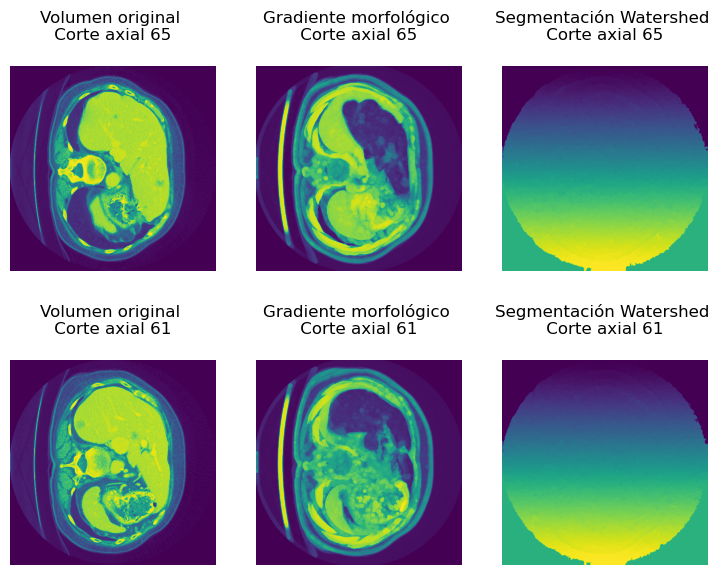

In [5]:
# Graficamos los resultados en 2 cortes axiales
fig, axs = plt.subplots(2,3, figsize=(9,7)) # ancho, alto
corte_axial1, corte_axial2 = 65, volume1.shape[2]//2

volumenes = [volume1, borders, watersheds_org]
nombres = ['Volumen original', 'Gradiente morfológico', 'Segmentación Watershed']

for j in range(3):
    axs[0,j].imshow(volumenes[j][:,:,corte_axial1])
    axs[0,j].axis('off')
    axs[0,j].set_title(f'{nombres[j]} \n Corte axial {corte_axial1} \n')
    
    axs[1,j].imshow(volumenes[j][:,:,corte_axial2])
    axs[1,j].axis('off')
    axs[1,j].set_title(f'{nombres[j]} \n Corte axial {corte_axial2} \n')    

plt.show()

In [6]:
print(f'La cantidad de segmentos es de {len(np.unique(watersheds_org))}. Se observa una gran sobresegmentación.')

La cantidad de segmentos es de 289114. Se observa una gran sobresegmentación.


### 1.2 h-minimos
Ahora, si vemos las estadisticas y la imagen que obtuvimos de la ultima celda de la subseccion anterior nos daremos cuenta que tenemos una sobresegmentación bastante considerable. Esto es debido a que estamos usando los minimos locales en toda la imagen. En esta nueva parte vamos a querer usar lo que son h-minimos, estos como saben nos van a ayudar a disminuir el efecto de la sobresegmentación por lo cual sacaremos los h-minimos con la funcion de ```skimage.morphology``` (https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.h_minima). Sace los h minimos del gradiente morfológico.

In [7]:
from skimage.morphology import h_minima

minima = ''#Variable que contendrá los h-minimos
# YOUR CODE HERE
minima = h_minima(borders, 0.05) # el h es menor a 1 porque estamos trabajando volumenes con valores entre 0 y 1

In [8]:
assert minima.shape == (512,512,123), f'Alteró el tamaño de su volumen de minimos, debe ser (512,512,123) no {minima.shape}'
assert minima.dtype=='uint8' ,f'su volumen debería ser de tipo uint8 no {minima.dtype}'
assert len(np.unique(minima))==2,f'sus minimos solo deberían tener 2 valores, no {len(np.unique(minima))}'

Ahora que ya hicimos el proceso de extracción de los h-minimos, si nos damos cuenta estos siguen teniendo unicamente valores de 1 y 0 por lo cual tendremos que usar la funcion ```label``` de la misma librería que hemos usado hasta el momento.(https://scikit-image.org/docs/stable/api/skimage.morphology.html#label) 

Esta lo que hará será permitirnos que temgamos un valor diferente para cada uno de las semillas, de modo que al entrar en watersheds generen segmentos diferentes

In [9]:
from skimage.morphology import label

markers = ''# Variable que tendrá los marcadores con sus respectivos labels
watersheds_h = '' #variable que tendrá el resultado de hacer watersheds
# YOUR CODE HERE
markers = label(minima)
watersheds_h = watershed(borders, markers=markers)

In [10]:
assert markers.shape == (512,512,123), f'Alteró el tamaño de su volumen de minimos, debe ser (512,512,123) no {markers.shape}'
assert markers.dtype=='int64' ,f'su volumen de marcadores debería ser de tipo int64 no {markers.dtype}'
assert watersheds_h.shape == (512,512,123), f'Alteró el tamaño de su volumen de watersheds, debe ser (512,512,123) no {watersheds_h.shape}'
assert watersheds_h.dtype=='int32' ,f'su volumen de watersheds debería ser de tipo int32 no {watersheds_h.dtype}'
assert len(np.unique(markers))-1==len(np.unique(watersheds_h)),f'sus minimos y su resultado de watersheds no tienen los mismos valores {len(np.unique(markers))} y{len(np.unique(watersheds_h))}'

Otra vez, visualice su volumen en almenos 2 cortes para ver lo que está sucediendo

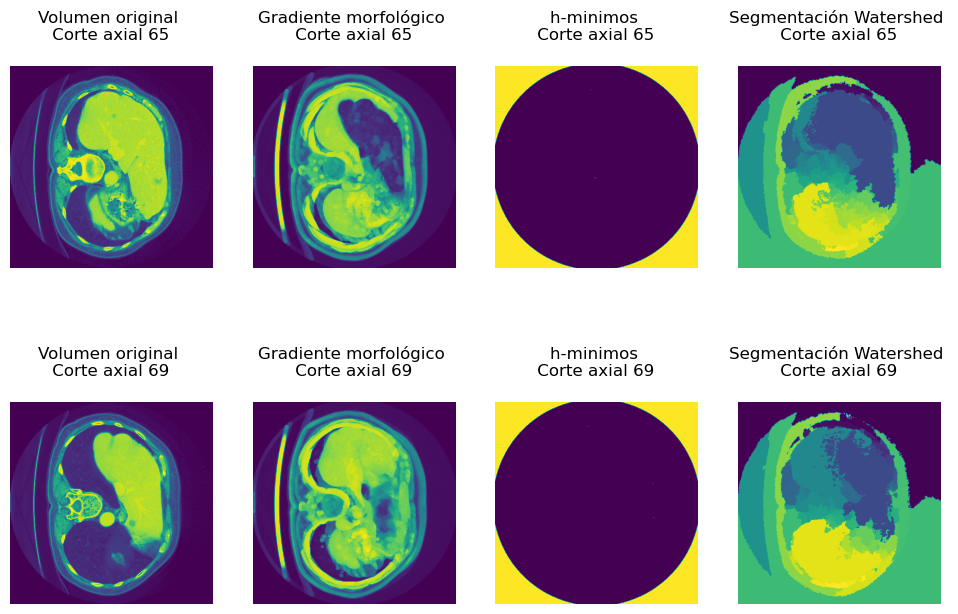

In [11]:
# Graficamos los resultados en 2 cortes axiales
fig, axs = plt.subplots(2,4, figsize=(12,8)) # ancho, alto
corte_axial1, corte_axial2 = 65, 69

volumenes = [volume1, borders, minima, watersheds_h]
nombres = ['Volumen original', 'Gradiente morfológico', 'h-minimos', 'Segmentación Watershed']

for j in range(4):
    axs[0,j].imshow(volumenes[j][:,:,corte_axial1])
    axs[0,j].axis('off')
    axs[0,j].set_title(f'{nombres[j]} \n Corte axial {corte_axial1} \n')
    
    axs[1,j].imshow(volumenes[j][:,:,corte_axial2])
    axs[1,j].axis('off')
    axs[1,j].set_title(f'{nombres[j]} \n Corte axial {corte_axial2} \n')    

plt.show()

In [12]:
print(f'La cantidad de segmentos es {len(np.unique(watersheds_h))}. Se disminuyó considerablemente la sobresegmentación.')

La cantidad de segmentos es 1389. Se disminuyó considerablemente la sobresegmentación.


### 1.3 Marcadores impuestos
Ahora, vimos que h-minimos si bien nos ayuda a que tengan un mejor resultado ya que hay una menor cantidad de segmentos estos siguen siendo mas de los que necesitamos por lo que unicamente queremos dos segmentos. Por esto vamos a realmente hacer un cambio de estos labels.

#### 1.3.1: Clasificación de semillas
Pudimos observar que cada región creada por watersheds tiene una label distinta establecida por la label original de su respectiva semilla. Esto quiere decir que las zonas cuya semilla tiene una misma label, tendrán la misma label una vez realzado watersheds. Usaremos esta idea de clasificar semillas con el fin de crear zonas con mayor robustes de pertenecer al higado. 

Como debemos recordar, las tareas de clasificación supervisada requieren etiquetas para el entrenamiento. En nuestro caso, tenemos labels de cada voxel de los volumenes, y su pertenencia o no al higado. Basicamente tenemos una liste enorme de datos que pertenecen a higado y datos que no. Ahora, requerimos un modelo de clasificación, una forma de determinar que elementos pertenecen y cuales no al higado, una metodología sencilla de determinar esto es el vecino más cercano. 

**Vecino más cercano:** Si contamos con una base de datos amplia y etiquetada, donde sabemos que un dato con determinadas caracteristicas pertenece a una clase, para saber la pertenencia de un nuevo dato de entrada a una clase especifica solo debemos calcular la distancia de nuestro nuevo dato a todos los datos de entrenamiento. Luego, seleccionamos el dato de menor distancia a nuestro nuevo dato y le asignamos la etiqueta del dato de entrenamiento. En este caso, las caracteristicas de los datos son numeros y las distancias que usaremos para comparar será la distancia euclideana:

$D=\sqrt{(a_{1}-b_{1})^{2}+(a_{2}-b_{2})^{2}+...+(a_{n}-b_{n})^{2}}$

Done $a_{1},...,a_{n}$ son las dimensiones del vector de caracteristicas de los datos de entrenamiento y $b_{1},...,b_{n}$ son las dimensiones del vector de caracteristicas del nuevo dato.

**Vector de caracteristicas:** Una forma de representar nuestros datos son mediante un vector, donde cada dimensión corresponde a una caracteristica del dato. Por ejemplo, si tuvieramos que representar a una persona mediante un vector, alguna dimensión puede guardar la información de la edad, la altura, el promedio de carrera, etc. En nuestro caso, nuestros datos son voxeles y las caracteristicas que usaremos para representar nuestros datos serán las intensidades. Sin embargo, usar solo un valor de intensidad para clasificar un voxel es una mala idea. Podemos, en cambio, usar un histograma de intensidades en la vecindad del voxel. 

Lo primero que debemos hacer es realizar una función de vecino más cercano. Esta función recibirá como parametro una tupla de arreglos de datos de entrenamiento y una lista de vectores a predecir. La tupla de datos de entrenamiento tendrá de primer valor el vector de caracteristicas y de segundo valor un vector de etiquetas. La función debe retornar un vector de etiquetas del mismo tamaño de la cantidad de vectores a predecir.

In [13]:
import numpy as np
from skimage.measure import label

def NN(train_data, predict):
    # YOUR CODE HERE
    
    predict_vector = [] # Inicializamos el vector a retornar
    train_vectors, train_etiquetas = train_data
    
    for pred_vector in predict:
        # Inicio variables de búsqueda
        distancia_minima = np.inf
        etiqueta_minima = None
        for j, train_vector in enumerate(train_vectors):
            # Para cada valor a predecir, se toma cada dato de entrenamiento
            suma = 0
            for i in range(len(train_vector)):
                suma += (train_vector[i]-pred_vector[i])**2
            # Se calcula la distancia entre el vector a predecir y el dato de train
            distancia = np.sqrt(suma) 
            # En caso de ser la menor, se actualiza la etiqueta a retornar
            if distancia < distancia_minima:
                distancia_minima = distancia
                etiqueta_minima = train_etiquetas[j]
        # Por último, se añade el mínimo encontrado
        predict_vector.append(etiqueta_minima)
                
    return predict_vector

In [14]:
train_data=([[0,0],[0,1],[1,0],[1,1]],[0,0,1,1])
predict=[[0,0.5],[1,0.5],[0.7,0],[0.3,0]]
predict_vector=NN(train_data,predict)

In [15]:
predict_vector

[0, 1, 1, 0]

In [16]:
assert len(predict_vector)==len(predict)
assert not np.sum(predict_vector-np.array([0,1,1,0])), 'Sus predicciones fueron erroneas'

#### 1.3.2: Datos de entrenamiento
Como dijimos anteriormente, usaremos voxeles de los volumenes de entrenamiento para entrenar nuestro clasificador. Para ello debemos sacar algunas muestras de nuestros datos, no podemos usarlos todos. Les daremos una función que entre por parametro el fold sobre el que sacaremos los voxeles (train, valid o test) junto con la cantidad de bins que usaremos para el histograma de intensidades de la vecindad, usaremos una vecindad de 3x3x3 al rededor del voxel. Esta función retorna una tupla de listas, la primera lista es de datos (el histograma de intensidades) y el segundo es de etiquetas (0 o 1 según la etiqueta dada en el volumen de segmentación). Debe retornar una cantidad minima de 1000 voxeles seleccionados aleatoriamente de cada volumen de entrenamiento (3000 voxeles en total) y un minimo de 100 voxeles positivos de cada volumen.

In [17]:
from glob import glob
from tqdm import tqdm

seed=np.random.seed(0)

def voxels_train(fold,bins):
    
    paths_v=glob(os.path.join('DB',fold,'volume*'))
    paths_s=glob(os.path.join('DB',fold,'segmentation*'))
    v=[]
    l=[]
    for i,pv in tqdm(enumerate(paths_v)):
        vol=nib.load(pv).get_fdata()
        seg=nib.load(paths_s[i]).get_fdata()>0
        x,y,z=vol.shape
        while np.sum(l)<100*(i+1):
            r1=np.random.randint(3,x-3)
            r2=np.random.randint(3,y-3)
            r3=np.random.randint(3,z-3)
            etiqueta=seg[r1,r2,r3]
            if etiqueta:
                etiqueta=1
            else:
                etiqueta=0
            if len(l)<1000*(i+1) or etiqueta==1:
                h,_=np.histogram(vol[r1-1:r1+2,r2-1:r2+2,r3-1:r3+2],bins=bins)
                v.append(h)
                l.append(etiqueta)
    
    return (v,l)
            

In [18]:
train_data_total=voxels_train('train',27)

3it [00:08,  2.89s/it]


In [19]:
etiquetas,cuenta=np.unique(train_data_total[1],return_counts=True)
assert np.isclose(np.sum(np.array(train_data_total[1])==1),300,0.1), f'Debería tener 300 datos positivos en su muestra y tiene {np.sum(train_data_total[1]==1)}'
assert len(etiquetas)==2, 'Solo deberíamos tener 2 etiquetas en la muestra'
assert np.max(etiquetas)==1 and np.min(etiquetas)==0, 'La maxima etiqueta debe ser 1 y la minima 0'
assert len(train_data_total[0])>3000, f'Su muestra debe tener al menos 3000 datos y tiene {len(train_data_total[0])}'
assert len(train_data_total[0][0])==27, 'Si se hizo un histograma de 27 bins, la dimensión del vector de caracteristicas debe ser 27'

Ahora, clasificar voxeles es una muy mala idea sabiendo la cantidad de datos que contiene un volumen. En cambio lo que haremos será seleccionar un punto adentro y un punto afuera del higado para realizar la segmentación usando watersheds. Los puntos no los buscaremos nostros, sino que usaremos unos voxeles que potencialmente contengan más información, en este caso usaremos los volumenes de h minima creados anteriormente. Adicionalmente, gracias a nuestro conocimiento del organo de interes, vamos a seleccionar unicamente algunas semillas que cumplan ciertas condiciones, esto con el fin de disminuir el peso computacional y aumentar la robustes del modelo. Las semillas que tendremos en cuenta son las que cumplan las las siguientes condiciones:

**Para las semillas positivas**
Usaremos nuestra función de segmentación por elemento conexo más grande 2D creado en anteriores entregas y crearemos un volumen de segmentación a priori. Es decir, un volumen segmentado a la primera que puede tener muchos errores pero que ya conocemos que muchos de sus voxeles si pertenecen al higado.

>- Las semillas creadas por h-minima que pertenezcan a su vez al volumen de segmentación a priori.
>- Las semillas que se encuentren unicamente en el slice 65 **axial**.
>- Consideramos positivas las semillas si cumplen las condiciones anteriores y su vecino más cercano en nuestra muestra de entrenamiento tiene una etiqueta de 1.

**Para las semillas negativas**
Sabemos que nuestros voxeles que no pertenecen al higado no tendrán intensidades superiores a 0.7, lo vimos en los hitogramas de la entrega pasada. Sin embargo, tampoco queremos quedarnos con semillas que solo sean el fondo de la resonancia, es decir que su intensidad sea 0.

>- La semilla creada por h-minima tiene una intesidad en el **volumen original** (sobre el que se calculó el h-minima) mayor a 0.1 y menor a 0.7.
>- Las semillas que se encuentren unicamente en el slice 65 **axial**.
>- Consideramos negativas las semillas si cumplen las condiciones anteriores y su vecino más cercano en nuestra muestra de entrenamiento tiene una etiqueta de 0.

Debemos recordar que nuestro volumen de H minima es un volumen donde todo es 0 menos en los voxeles marcados, que tienen una intensidad de 1. Cree una matriz de 0s del tamaño de la resonancia, recorra su volumen de H minima en el slice 65 buscando los voxeles cuya intensidad es 1. 

> Si el voxel i,j del **volumen H minima** pertenece a el **volumen de segmentación a priori**, prediga su etiqueta con el clasificador NN, si la etiqueta es 1 entonces cambie la intensidad del voxel i,j en la **matriz de 0s** por un **2**.

> Si el pixel i,j del **volumen H minima** no pertenece a el volumen de segmentación a priori y su intensidad en el volumen original es mayor a 0.2 y menor a 0.7, prediga su etiqueta con el clasificador NN, si la etiqueta es 0 entonces cambie la intensidad del voxel i,j en la matriz de 0s por un **1**. 

**Nota:** Se le recomienda usar el gradiente morfologico usando una bola de radio 5 para el correcto desarrollo de este punto. Los H minimos se calculan sobre este volumen.

Use la siguiente celda para copiar sus funciones de segmentación

In [20]:
from tqdm import tqdm

def Vol2D_max_component(Vol,umbral,operador):
    # YOUR CODE HERE
    segmentacion = np.zeros(Vol.shape)
    for i in range(Vol.shape[2]):
        segmentacion[:,:,i] = max_component(Vol[:,:,i], umbral, operador)
    return segmentacion

def max_component(Im,umbral,operador):
    'Im (ndarray): Imagen a segmentar'
    'umbral (float): Umbral a utilizar'
    'operador (str): Puede ser "mayor" para > o "menor" para < segun se quiera umbralizar'
    # YOUR CODE HERE
    
    # Umbralizamos
    if operador == 'mayor':
        Im = Im > umbral
    elif operador == 'menor':
        Im = Im < umbral
    
    # encontramos el label del mayor componente
    labeled_img, n_labels = label(Im, return_num=True)
    label_mayor, label_count = 0, 0
    for label_i in range(1, n_labels+1):
        label_i_count = np.sum(labeled_img==label_i)
        if label_i_count > label_count:
            label_mayor = label_i
            label_count = label_i_count
    
    # encontramos el mayor componente
    max_comp = (labeled_img == label_mayor) * Im
    return max_comp

In [21]:
#Creando el volumen a priori
vol1='' #Volumen volume-1.nii
segmentacion_priori=''#volumen de segmentación a priori
seg1='' #Volumen segmentation-1.nii

# YOUR CODE HERE
vol1 = volume1 # o debería volverlo a cargar?
seg1 = nib.load(glob(os.path.join('DB','train','segmentation-1.nii.gz'))[0]).get_fdata() # convertir los 2 en 1?
segmentacion_priori = Vol2D_max_component(vol1, 0.8, 'mayor')

Use la siguiente celda para obtener el volumen de semillas clasificadas.

In [22]:
negative=0 #Numero de negativos obtenidos
positive=0 #Numero de positivos obtenidos
minima2='' #Volumen de semillas clasificadas
# YOUR CODE HERE
minima2=np.zeros(vol1.shape)
minima_test = h_minima(borders, 0.01) # se usa un h menor

# Recorrer h_minima en slice 65 buscando voxeles de intensidad 1
for i in range(minima_test[:,:,65].shape[0]):
    for j in range(minima_test[:,:,65].shape[1]):
        if (minima_test[i,j,65] == 1):
        
            if segmentacion_priori[i,j,65] == 1:
                #print('dentro')
                h,_=np.histogram(vol1[i-1:i+2,j-1:j+2,65-1:65+2],bins=27)
                etiqueta = NN(train_data_total, [h])[0]
                if etiqueta == 1:
                    #print(f'pos: {i,j}')
                    positive += 1
                    minima2[i,j,65] = 2
            else:
                #print('fuera')
                if vol1[i,j,65]>0.1 and vol1[i,j,65]<0.7:
                    h,_=np.histogram(vol1[i-1:i+2,j-1:j+2,65-1:65+2],bins=27)
                    etiqueta = NN(train_data_total, [h])[0]
                    if etiqueta == 0:
                        #print(f'neg: {i,j}')
                        negative += 1
                        minima2[i,j,65] = 1

Visualice sus semillas en el volumen de bordes en ell slice 65. Las semillas son puntos asi que para visualizarlas mejor hagales una apertura **solo para visualizarlas**. Puede hacer slice+dilatacion(bordes).

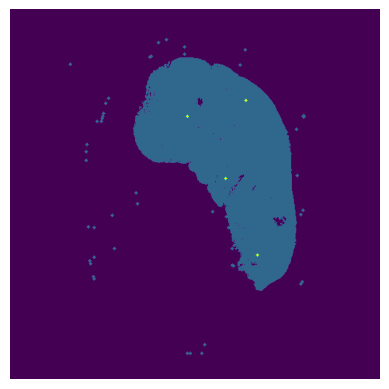

In [23]:
# YOUR CODE HERE
from skimage.morphology import closing, disk

# Graficamos los resultados en el corte axial 65
#plt.imshow(minima2[:,:,65])
#plt.show()
#plt.imshow(dilation(minima2[:,:,65],footprint=disk(3))+borders[:,:,65])
plt.imshow(dilation(minima2[:,:,65],footprint=disk(2)) + segmentacion_priori[:,:,65])
plt.axis('off')
plt.show()

In [24]:
etiquetas, cantidades= np.unique(minima2,return_counts=True)
assert negative and positive, 'Deben haber más de un positivo y un negativo en sus semillas, de no ser así, intente obtener más minimos con h-minimos bajando el h'
assert len(minima2.shape)==3, 'Las dimensiones del volumen de minima2 deberían ser 3'
assert np.sum(minima2[:,:,65]), 'Las semillas deben estar en el slice 65 axial'
assert len(etiquetas)==3, f'Deberían haber 3 etiquetas diferentes en el volumen de etiquetas clasificadas y son {len(etiquetas)}'
assert np.max(etiquetas)==2, f'El valor de la etiqueta maxima debe ser 2 y es {np.max(etiquetas)}'
assert np.min(etiquetas)==0, f'El valor de la etiqueta minima debe ser 0 y es {np.min(etiquetas)}'
assert cantidades[0]>=1 and cantidades[1]>=1 and cantidades[2]>=1, 'Debería haber al menos una etiqueta de cada una en su volumen'

indicesx,indicesy,indicesz=np.where(minima2==2)
h,_=np.histogram(vol1[indicesx[0]-1:indicesx[0]+2,indicesy[0]-1:indicesy[0]+2,indicesz[0]-1:indicesz[0]+2],bins=27)
result=NN(train_data_total,[h])
assert result[0]==1, f'Usted asignó con la etiqueta 2 a una predicción de negativa, las predicciones negativas deben ser 1 y las positivas 2'

indicesx,indicesy,indicesz=np.where(minima2==1)
h,_=np.histogram(vol1[indicesx[0]-1:indicesx[0]+2,indicesy[0]-1:indicesy[0]+2,indicesz[0]-1:indicesz[0]+2],bins=27)
result=NN(train_data_total,[h])
assert result[0]==0, f'Usted asignó con la etiqueta 2 a una predicción de negativa, las predicciones negativas deben ser 1 y las positivas 2'

Ahora, usando estas semillas, cree 2 volumenes segmentados diferentes usando watersheds. Use como imagen a segmentar, por un lado, el volumen de gradiente morfológico en escala de grises (volumen original) y, por otro lado, el volumen de gradiente morfológico binario (volumen segmentado). Luego de segmentar don watersehds, reste 1 a cada etiqueta.

In [25]:
borders_binary='' #Volumen del gradiente morfológico binario
borders='' #Volumen del gradiente morfológico en escala de grises
# YOUR CODE HERE
borders_binary = morph_gradient(seg1, element) # seg1 o segmentacion_priori?
borders = morph_gradient(vol1, element)

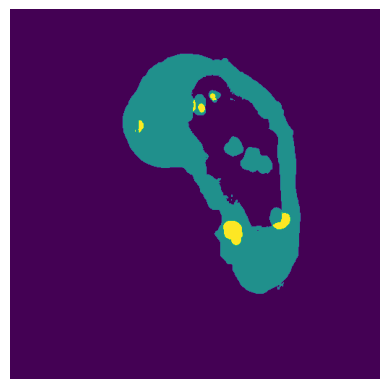

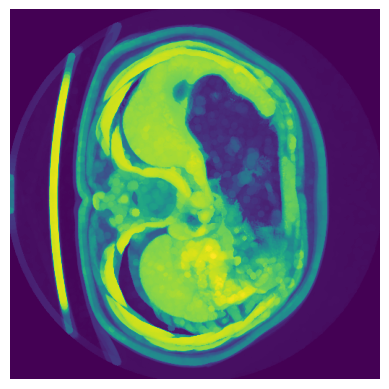

In [26]:
plt.imshow(borders_binary[:,:,66])
plt.axis('off')
plt.show()
plt.imshow(borders[:,:,66])
plt.axis('off')
plt.show()

In [27]:
new_segment_vol_binary='' #Volumen segmentado con watersheds usando gradiente binario
new_segment_vol_gray='' #Volumen segmentado con watersheds usando gradiente grises
# YOUR CODE HERE
new_segment_vol_binary = watershed(borders_binary, markers=minima2)-1
new_segment_vol_gray = watershed(borders, markers=minima2)-1

Evalue sus nuevos volumenes segmentados, visualizelos tambien ¿ve alguna diferencia?

El Jaccard es de 0.8639761475701253


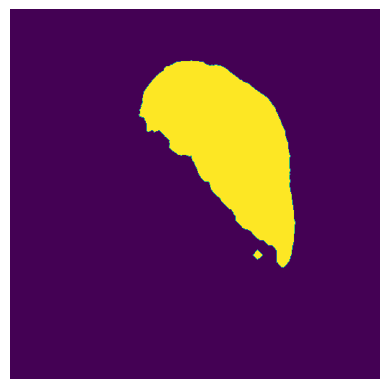

El Jaccard es de 0.25073126458815365


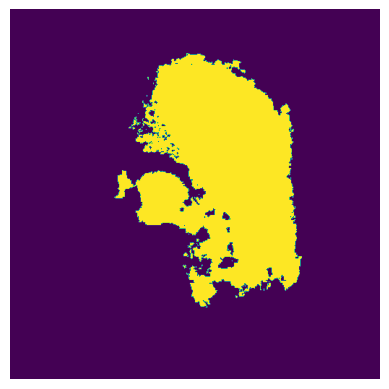

In [28]:
def Jaccard_3D(Im,Gt):
    '''
    :param Im: Volumen de prediccion.
    :param Gt: Segmentacion groundtruth.
    '''
    # YOUR CODE HERE
    inter = np.sum ( np.logical_and(Im, Gt) )
    union = np.sum( np.logical_or(Im, Gt) )
    J = inter / union
    return J

# YOUR CODE HERE
plt.imshow(new_segment_vol_binary[:,:,66])
plt.axis('off')
print(f'El Jaccard es de {Jaccard_3D(new_segment_vol_binary, seg1)}')
plt.show()
plt.imshow(new_segment_vol_gray[:,:,66])
plt.axis('off')
print(f'El Jaccard es de {Jaccard_3D(new_segment_vol_gray, seg1)}')
plt.show()

In [29]:
assert len(np.unique(new_segment_vol_binary))==2, 'Solo debeían haber 2 etiquetas en su volumen de segmentación'
assert len(np.unique(new_segment_vol_gray))==2, 'Solo debeían haber 2 etiquetas en su volumen de segmentación'
assert np.max(new_segment_vol_binary)==1, 'El maximo de su volumen de segmentación debería ser 1'
assert np.max(new_segment_vol_gray)==1, 'El maximo de su volumen de segmentación debería ser 1'
assert np.min(new_segment_vol_binary)==0, 'El minimo de su volumen de segmentación debería ser 0'
assert np.min(new_segment_vol_gray)==0, 'El minimo de su volumen de segmentación debería ser 0'
assert Jaccard_3D(new_segment_vol_binary,seg1>0)>0.5, 'Su volumen seguramente fue mal segmentado, puede deberse a la clasificación de sus semillas'
assert Jaccard_3D(new_segment_vol_gray,seg1>0)>0.2, 'Su volumen seguramente fue mal segmentado, puede deberse a la clasificación de sus semillas, intente usar un hminima de 0.01'

#### **Condicionar segmentos**
La segunda estrategia que usaremos es condicionar el segmento ya hecho. Para esto lo que vamos a hacer es primero realizar watersheds con h_minima, y apenas tengamos nuestros fragmentos lo que realizaremos será recortar la segmentación del **volumen a priori** usado anteriormente y determinar que si mas de la mitad de los voxeles del segmento pertenecen a una clase consideraremos que todo el segmento pertenece a dicha clase. Al final de esto deberíamos quedar unicamente con 1s y 0s.

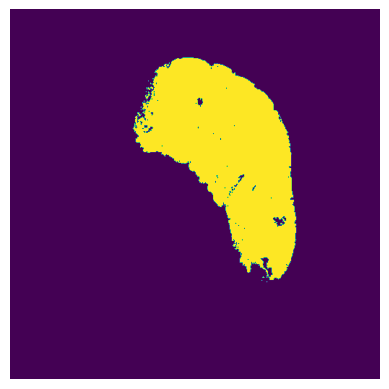

In [30]:
watersheds_imposed_seg='' #volumen segmentado condicionando segmentos
watersheds_h='' #volumen sobresegmentado con watersheds y h minimos usando borders como mascara
# YOUR CODE HERE
watersheds_h = watershed(borders, markers=label(h_minima(borders, 0.05)))
watersheds_imposed_seg = np.zeros(watersheds_h.shape)
for label in np.unique(watersheds_h):
    segmento = (watersheds_h == label).astype(int)
    voxeles_segmento = np.sum(segmento)
    interseccion = segmentacion_priori*segmento 
    voxeles_segmento_in = np.sum(interseccion)
    if voxeles_segmento_in > voxeles_segmento/2:
        watersheds_imposed_seg[interseccion==1] = 1
plt.imshow(watersheds_imposed_seg[:,:,65])
plt.axis('off')
plt.show()

In [31]:
assert watersheds_imposed_seg.shape == (512,512,123), f'Alteró el tamaño de su volumen de segmentacion, debe ser (512,512,123) no {watersheds_imposed_seg.shape}'
assert len(np.unique(watersheds_imposed_seg))==2,f'su volumen debería tener solo 1s y 0s de etiquetas, no deberia tener {np.unique(watersheds_imposed_seg)}'                                                   
assert len(np.unique(watersheds_imposed_seg))!=1,f'su volumen tiene una unica etiqueta, revise los h que está usando'

labels=np.unique(watersheds_h)
etiqueta=(np.max(labels)-np.min(labels))//2

valor=np.sum(segmentacion_priori*(watersheds_h==etiqueta))/np.sum(watersheds_h==etiqueta)

assert (valor>=0.5 and np.sum((watersheds_h==etiqueta)*watersheds_imposed_seg)) or (valor<0.5 and not np.sum((watersheds_h==etiqueta)*watersheds_imposed_seg)), 'El segmento tiene mas voxeles positivos en el volumen a priori y se asignó la etiqueta equivocada o viseversa'

Ahora que ya tenemos esto vamos a compararlo con nuestro volumen de anotación y saquemos el indice de Jaccard

In [32]:
print(f'El Jaccard es de {Jaccard_3D(watersheds_imposed_seg, seg1)}')

El Jaccard es de 0.6496191076809114


## Parte 2: Super-pixeles
Ahora, otro uso que tambien nos puede dar watersheds es permitirnos usar super pixeles. Esta es una aproximacion que se le puede hacer a la tarea de segmentación por medio de la clasificacion. El principio de esto es que basicamente se puede tomar la tarea de segmentacion como una tarea de clasificacion de pixeles, es decir, vamos a clasificar cada pixel como algo. Sin embargo, esta tarea puede tener una gran dificultad ya que un solo pixel aveces no nos da la informacion necesaria para poder determinar su etiqueta. De esta falla es que nacen los super pixeles. Con estos podemos tomar fragmentos completos de las imagenes y usarlos para así poder usar sus estadisticas para tomar una decisión, que resulta mejor que unicamente tomar en cuenta un solo pixel. 

### 2.1 Muestras de entrenamiento
Ahora lo que haremos es la parte mas interesante del proceso y es sacar nuestras muestras de entrenamiento, ya que este será nuestro primer algoritmo supervisado. Lo que haremos será el siguiente proceso:
- Segmentar nuestro volumen usando h-minimos
- Para cada segmento recortaremos el volumen de anotacion.
- Revisaremos si el recorte pertenece mas a higado o a fondo **segun el groundtruth**.
- Creamos una lista de datos y una lista de etiquetas. El dato será el histograma NORMALIZADO del recorte y la etiqueta será 0 o 1 si el recorte pertenece mas al fondo o hígado respectivamente. Agregamos cada segmento a las listas.
Esto lo repetiremos para los 3 volumenes de entrenamiento para sacar todas las muestras que necesitemos.

#### 2.1.1 Obtención de segmentos
Cree una función que entre como parametro el volumen original, volumen sobresegmentado, el volumen groundtruth, un numero de bins con el cual calcular el histograma y la etiqueta del segmento sobre la cual se desea calcular el hitograma. La función debe retornar una tupla (histograma,label). Donde histograma es el histograma del segmento con las intensidades del volumen original y label es la label del segmento.

In [33]:
def dato_unico(Vol,Vol_seg,Seg,bins,etiqueta):
    'Vol (ndarray): Volumen original'
    'Vol_seg (ndarray): Volumen sobresegmentado'
    'Seg (ndarray): Volumen groundtruth binario'
    'bins (int): Numero de bins para el histograma'
    'etiqueta (int): Numero de la etiqueta del segmento a evaluar'
    # YOUR CODE HERE
    raise NotImplementedError()
    return hist,label

In [34]:
segmentos_p=np.unique(watersheds_h[:,:,65]*seg1[:,:,65])
h,l=dato_unico(vol1,watersheds_h,seg1,40,segmentos_p[1])
h2,l2=dato_unico(vol1,watersheds_h,seg1,40,40)

assert l==1, 'Este segmento debería tener etiqueta de 1'
assert l2==0, 'Este segmento debería tener etiqueta de 0'
assert np.sum(h2)==1 and np.sum(h)==1, 'Los histogramas no estan normalizados'
assert len(h2)==40, 'La longitud del histograma debe ser igual a la cantidad de bins especificada'
assert h[0]<0.5, 'No incluya el fondo en su histograma'

NotImplementedError: 

#### 2.1.2 Segmentos por volumen
Ya tenemos una función que nos retorna el histograma de un segmento y su etiqueta teniendo en cuenta el volumen de groundtruth. Ahora, cree una función que reciba por parametro el volumen original, el volumen segmentado, un hminimo y el numero de bins. Esta función debe sobresegmentar el volumen del gradiente morfologico (use una bola de radio 2 para esto) con los h minimos por parametro (no olvide usar la función labels para asignarle una etiqueta a cada segmento). Luego, obtener el histograma y la etiqueta de cada segmento usando la función *dato_unico* y poniendo cada valor en una lista. Esta función debe retornar una tupla (histogram_list,labels_list) donde histogram_list es una lista de histogramas de cada segmento y labels_list es una lista de etiquetas de cada segmento.

In [ ]:
from skimage.measure import label
from skimage.segmentation import watershed
def Volume_dataset(Vol,Seg,hminimos,bins):
    'Vol (ndarray): Volumen original'
    'Seg (ndarray): Volumen groundtruth binario'
    'hminimos (float): Valor para imponer h minimos'
    'bins (int): Numero de bins para el histograma'
    # YOUR CODE HERE
    raise NotImplementedError()
    return histogram_list,label_list

In [ ]:
#ADVERTENCIA
#Este codigo tarda mucho en correr, mas o menos 40 minutos
h_lists,l_lists=Volume_dataset(vol1,seg1,0.1,40)

In [ ]:
assert len(h_lists)>0, 'Su lista está vacía'
assert len(h_lists)==len(l_lists), 'Debe tener igual cantidad de datos que de etiquetas'
assert len(h_lists[0])==40, 'La longitud de el vector de caracteristicas debe ser 40'
assert np.max(l_lists)==1, 'La etiqueta maxima debe ser 1'
assert np.min(l_lists)==0, 'La etiqueta minima debe ser 0'

Una idea sería aprovechar todos los volumenes de entrenamiento para obtener la mayor cnatidad de datos y tener un modelo generalizable. Sin embargo, en nuestro caso es algo muy costoso computacionalmente. Si desea intentar obtener una lista de todos los datos de la base de datos puede submuestrear, pregunte a su asistente de laboratorio si desea intentarlo.

En este caso, por simplicidad, usaremos los datos de un unico volumen.

### 2.2 Predicción
Ya tenemos una lista de etiquetas e histogramas de superpixeles. Ahora, usaremos nuestra función de NN creada anteriormente para segmentar nuestro volumen. Cree una función que entre por parametro un volumen, una segmentación a priori del volumen, un hminimo, un valor de bins, la lista de histogramas y la lista de etiquetas de entrenamiento creadas anteriormente. Esta función debe sobresegmentar el volumen de entrada usando de semillas los hminimos **etiquetados** y de mascara el gradiente morfológico (con bola de radio 2). Multiplique esta sobresegmentación con el volumen de segmentación a priori. Luego, debe recorrer superpixel por superpixel y clasificando cada uno. Cree una matriz de ceros del tamaño del volumen y, si el superpixel en el volumen sobresegmentado es clasificado como 1, se pinta el superpixel en el volumen de ceros. Retorne este volumen segmentado.

**Nota:** A la hora de clasificar los superpixeles no tiene porque clasificar el superpixel con etiqueta 0. Esto se debe a que, al multiplicar nuestra segmentación a priori con el volumen sobresegmentado, los voxeles 0 serán unicamente aquellos que consideramos que no pertenecen a el higado.

In [ ]:
def Predict(Vol,Seg,hminimos,bins,h_lists,l_lists):
    'Vol (ndarray): Volumen original'
    'hminimos (float): Valor para imponer h minimos'
    'bins (int): Numero de bins para el histograma'
    'h_list (list): Lista de histogramas'
    'l_lists (list): Lista de etiquetas'
    # YOUR CODE HERE
    raise NotImplementedError()
    return final_segment

In [ ]:
seg_priori='' #volumen de segmentación a priori
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
#ADVERTENCIA
#Este codigo puede demorarse en correr unos 20 minutos
final_segment=Predict(vol1,seg_priori,0.1,40,h_lists,l_lists)

In [ ]:
assert np.max(final_segment)==1, 'La etiqueta maxima de la segmentación final debe ser 1'
assert np.min(final_segment)==0, 'La etiqueta minima de la segmentación final debe ser 0'
assert len(np.unique(final_segment))==2, 'Solo deben haber 2 etiquetas en su volumen'
x,y,z=final_segment.shape
x2,y2,z2=vol1.shape
assert x==x2 and y==y2 and z==z2, 'Las dimensiones de su segmentación no coinsiden con las de su volumen original'
assert Jaccard_3D(final_segment,seg1)>0.45, 'La segmentación final es muy mala, pruebe bajando los hminimos o cambiando la segmentación a priori'

Ahora que ya tenemos esto vamos a compararlo con nuestro volumen de segmentación y saquemos el indice de Jaccard y verifique algunos cortes para evaluar cualitativamente su algoritmo

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Parte 3 Validación
Ya hemos creado nuestra función de predicción y hemos verificado su funcionamiento en entrenamiento, es momento de la experimentación. Debe realizar los experimentos y evaluarlos en **Validación**. Puede usar lo que aprendió de pre-procesamiento, post-procesamiento y el algoritmo de segmentación de su preferencia (superpixeles, condicionar segmentos, clasificación de semillas, umbralización, entre otros) Pero debe recordar la experimentación exhaustiva. Ya hemos experimentado con pre y post procesamiento en la entrega  pasada, por lo que se le recomienda establecer un procedimiento estandar para estos pasos (no requiere experimentar nuevamente con ello).

Debe realizar al menos 4 experimentos en el algoritmo que escogió y debe justificar su elección en el informe. Calificaré de igualforma su creatividad y sus resultados, no tengan miedo de probar cosas. Usaremos de baseline la segmentación por elemento conexo mayor.

Cree una función que entre como parametro un volumen y retorne su segmentación con el algoritmo final.

**Pista:** El slice de mayor area axial de higado en validación es la 446. Esta información se le proporciona, usted no puede ver ni manipular el volumen de validación.

In [ ]:
def Segmentacion(Vol):
    # YOUR CODE HERE
    raise NotImplementedError()
    return seg_total

In [ ]:
vol_val=nib.load(os.path.join('DB','valid','volume-10.nii.gz')).get_fdata()
seg_val=nib.load(os.path.join('DB','valid','segmentation-10.nii.gz')).get_fdata()
seg_total=Segmentacion(vol_val)

In [ ]:
assert len(np.unique(seg_total))==2, 'Solo deberían haber 2 etiquetas en su volumen'
assert np.max(seg_total)==1, 'El maximo de su segmentación debería ser 1'
assert Jaccard_3D(seg_total,seg_val)>0.49, 'Su experimentación debería superar el 0.51 de Jaccard, el baseline'

## Prueba
Ahora es momento de hacer la prueba, ya hicimos todo este proceso en el conjunto de validación durante estas ultimas dos entregas, ya conseguimos nuestra mejor metodología. Ahora lo que nos queda es correr este algoritmo en el volumen de prueba y así poder observar el desempeño final de nuestro algoritmo.
Además hagan un subplot con almenos 4 cortes axiales donde se pueda apreciar la calidad de la segmentación.

In [ ]:
vol_val=nib.load(os.path.join('DB','test','volume-7.nii.gz')).get_fdata()
seg_val=nib.load(os.path.join('DB','test','segmentation-7.nii.gz')).get_fdata()
seg_total=Segmentacion(vol_val)

In [ ]:
assert Jaccard_3D(seg_total,seg_val)>0.48, 'Su algoritmo final debería superar el baseline'

# Informe
### Parte 1: watersheds
- ¿Que puede notar en su implementación original de watersheds?¿Cuantos segmentos hay?
- Proponga otra forma de conseguir etiquetas para los segmentos o las semillas.
- ¿Que tan validas son las suposiciones que hicimos sobre las semillas negativas? ¿Siempre es valido solo clasificar semillas en un solo slice?
- La metodología de la clasificación de semillas ¿Que caracteristicas del objeto utiliza para segmentarlo, forma, textura, intensidad, entre otros? Justifique su respuesta
- En cuanto a el uso de la segmentación a priori ¿Es preferible una alta cobertura o una alta precisión en este caso en particular?
- ¿Son diferentes sus segmentaciones usando como mascara el gradiente morfológico en grises y binario? ¿Porqué puede suceder esto?
- ¿Que tan valido es considerar que un segmento es positivo si más de la mitad de los voxeles pertenecen a la segmentación a priori? ¿De que otra forma podemos clasificar esos segmentos usando la segmentación a priori?
- ¿Que limitaciones encuenta en cada metodología?

### Parte 2: Super pixeles
- ¿Por que cree que es necesario usar una segmentación a priori para clasificar los superpixeles?
- ¿Por que no clasificamos los pixeles o voxeles uno por uno en vez de hacer superpixeles?
- ¿Que otra información podría incluir para el proceso de clasificacion de super pixeles?
- ¿Como considera la calidad de sus resultados?¿siente que podría mejorarlos?

### ¡Prueba!
- Incluyan los resultados del indice de Jaccard, incluyendo el subplot.
- ¿Fueron congruentes sus resultados en prueba con los hechos en validación? ¿Por qué cree que su metodo funciona bien en entrenamiento y mal en validación y test? Observe los volumenes de validación y test si es necesario para contestar.
- ¿Consideran que cualquiera de las 3 aproximaciones que hicimos fueron competentes para resolver este problema?
- ¿Que problemas pueden ver en sus resultados cualitativos?
- ¿Como mejorarían su metodo?

In [ ]:
from utils import *
converter("Entrega 3")